# ECE227: Homework 4

## Task 1: Heuristically Optimized Trade-offs (HOT) Based Models
### Part 1:
### In this part of the task you are going to generate a random network based on a simple optimization criteria: Each newly added node ($i$) which has a uniformly random position $(x,y)$ on a unit square, takes into account its distance ($d_{ij}$) to other nodes ($j<i$) as well as the hop count ($h_j$) from that node to a central node in the network to decide which node to connect to. The node to connect to is chosen as follows:
### $$node = argmin_{j<i} \   \alpha d_{ij} + h_j $$
### Here $ \alpha $ is a parameter gauging the relative importance of the two objectives.
### You are supposed to:
### -- Generate a network with $n=500$ nodes based on the above optimization model with $\alpha = 5$. Here, choose the first node as the central node.
### -- Visualize the network using NetworkX built-in visulization method which can take into account the position of each node on the plane as well (nx.draw()). Make sure to highlight the central node with a different color using nx.draw_networkx_nodes().
### -- Plot the degree distribution and decide whether it is close to a Binomial, Exponential, or Power law distribution in your opinion.
### -- Repeat the task for $\alpha = 1,10,100 $ and compare the results.

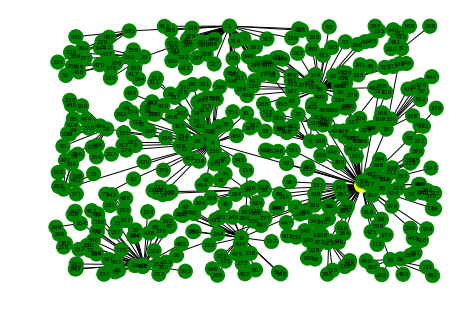

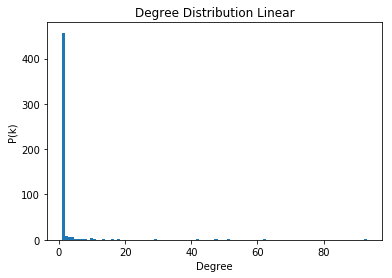

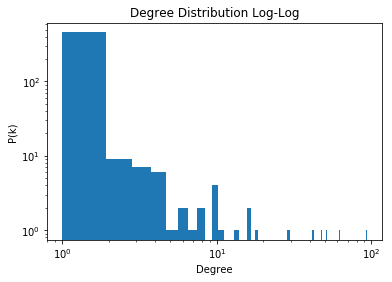

In [5]:

import networkx as nx
import numpy as np 
import matplotlib.pyplot as plt 
import powerlaw 


G = nx.random_geometric_graph(500,.1)

G2 = nx.create_empty_copy(G)

def hot_gen(G,alpha):
    
    G.add_edge(0,1)
    
    for i in range(2,len(G.nodes())):
        min_index = 0
        min_val = 10000
        for j in range(0,i):
            dist = np.array(G.node[i]['pos']) - np.array(G.node[j]['pos'])
            dist = np.linalg.norm(dist)
            to_center = nx.shortest_path_length(G,j,0)
            dist = alpha * dist + to_center
            if dist < min_val:
                min_val = dist
                min_index = j 
        
        G.add_edge(i,min_index)
    
    return G

def pos_dict_generator(G):
    dic = {}
    for node in G.nodes():
        dic[node] = G.node[node]['pos']
    
    return dic


G3 = hot_gen(G2,5)
pos_dic = pos_dict_generator(G3)
color = ['yellow']
for i in range(499):
    color.append('green')
nx.draw(G3,pos_dic,node_color=color,with_labels=True,node_size=200,font_size=6)
plt.show()

def plot_degdist_linear(G):
    deg = [G.degree(n) for n in G.nodes()]
    plt.hist(deg,100)
    plt.xlabel('Degree')
    plt.ylabel('P(k)')
    plt.title('Degree Distribution Linear')
    plt.show()

def plot_degdist_log(G):
    deg = [G.degree(n) for n in G.nodes()]
    plt.hist(deg,100)
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Degree Distribution Log-Log')
    plt.xlabel('Degree')
    plt.ylabel('P(k)')
    plt.show()

plot_degdist_linear(G3)
plot_degdist_log(G3)

### Part 2: 
### In this part of the task you are given a core network inspired by an actual infrastructure and you are supposed to connect random nodes to the nodes of this core network according to a power law. Then you are supposed to calculate a performance measure for this network. 
### Then, you are supposed to create a preferential attachment random graph based on the Barabasi-Albert model with the same number of nodes and compare the perfomance measure of this network to the first network. 
### Create the following graph in NetworkX.

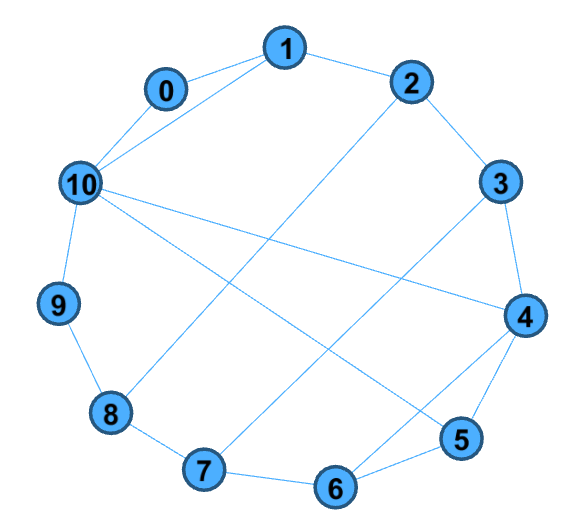

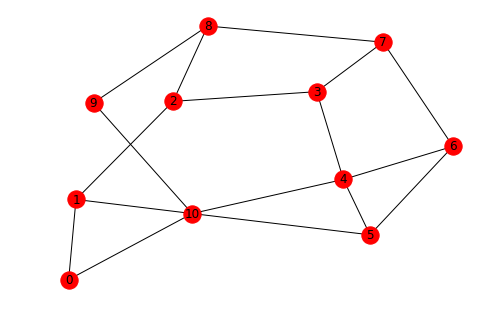

In [3]:
import networkx as nx
import numpy as np 
import matplotlib.pyplot as plt 
import powerlaw 

C = nx.cycle_graph(11)
edg = [(1,10),(2,8),(3,7),(4,6),(5,10),(4,10)]
C.add_edges_from(edg)
nx.draw(C,with_labels=True)

### To each node of the above core network connect random number of new nodes according to a power law distribution with mean 10 and $\alpha = 3$.

Name: 
Type: Graph
Number of nodes: 114
Number of edges: 120
Average degree:   2.1053


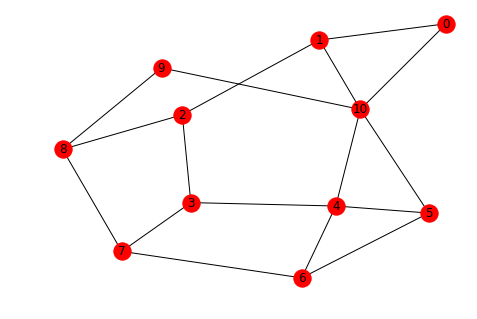

In [4]:
C = nx.cycle_graph(11)
edg = [(1,10),(2,8),(3,7),(4,6),(5,10),(4,10)]
C.add_edges_from(edg)
nx.draw(C,with_labels=True)

lst = []
rv = powerlaw.Power_Law(xmin=5,discrete=True,parameters=[3])

simulated_data = rv.generate_random(10)

def new_net(G):
    count = 0
    run = len(G.nodes())
    numb = len(G.nodes())
    while count < numb:
        sim_data = rv.generate_random(1)
        lst = np.arange(sim_data[0])
        lst += run
        run += lst[-1]
        G.add_nodes_from(lst)
        for i in lst:
            one,two = i,count
            G.add_edge(one,two)
        count += 1
    
    return G



C2 = new_net(C)
print(nx.info(C2))


### Visualize the resulted graph using gephi and include the visualization in SVG format in your notebook.

![Powerlaw_Graph](powerlawgraph.png)

### For each pair of the newly added nodes perform shortest-path routing using NetworkX and create a binary matrix $R$ such that each row of the matrix correspond to a core node and each column correspond to an ordered pair of newly added nodes. Each element of this matrix is "one" if the shortest path between the corresponding pair goes through the corresponding core node and "zero" otherwise. This matrix is sometimes called the routing matrix.

In [5]:
C2 = nx.convert_node_labels_to_integers(C2)



def routing_matrix2(G):
    lst = []
    paths = dict(nx.shortest_path(G))
    for i in range(11,len(G.nodes())):
        for j in range(i+1,len(G.nodes())):
            lst.append(paths[i][j])
    
    A = np.zeros((11,len(lst)))
    
    for i in range(len(lst)):
        for k in range(11):
            if k in lst[i]:
                A[k][i] = 1
    return A

R = routing_matrix2(C2)
length,width = np.shape(R)
print(width)
print(length)

5253
11


### Find the solution to the following linear programming using the $cvxpy$ library:
### $$ Maximize \sum X_{i,j} $$
### $$ s.t. \ \ X_{i,j} \ge 0 , RX\le B  $$

### Here, $B$ is a vector containing the maximum bandwidth of each of the core nodes. In this homework assume that all the elements of this vector are set to 10.

In [6]:
#!pip install cvxpy
import cvxpy as cp

R = routing_matrix2(C2)

length,width = np.shape(R)
print(width)
print(length)

X = cp.Variable(width)
b = np.ones(11)*10


objective = cp.Maximize(sum(X))
constraints = [0 <= X, R@X<=b]

prob = cp.Problem(objective,constraints)


result = prob.solve()
print(result)


5253
11
110.00000000415996


### Now create a Barabasi-Albert random graph with the same number of nodes as the previous graph and $m=1$ and visualize it using Gephi.

In [12]:
barbnodes = len(C2.nodes())

GB = nx.barabasi_albert_graph(barbnodes,1)
print(nx.info(GB))

#nx.write_gml(GB,'barbasi.gml')



Name: 
Type: Graph
Number of nodes: 114
Number of edges: 113
Average degree:   1.9825


![Barbasi_albert_m=1](Barbasi_Albert_routing.png)


### Calculate the routing matrix for this random graph with the first 11 nodes as the core. (Ignore the pairs whose shortest path does not go through the core.)

In [14]:
def routing_matrix3(G):
    lst = []
    paths = dict(nx.shortest_path(G))
    for i in range(11,len(G.nodes())):
        for j in range(i+1,len(G.nodes())):
            count = 0
            for k in range(11):
                if k in paths[i][j]:
                    count += 1
            
            if count > 0:
                lst.append(paths[i][j])
    
    A = np.zeros((11,len(lst)))
    
    for i in range(len(lst)):
        for k in range(11):
            if k in lst[i]:
                A[k][i] = 1
    return A

RR = routing_matrix3(GB)
length2,width2 = np.shape(RR)

### Now solve the previous optimization problem for this random graph and compare the result with the previous result. Which network has a higher performance? Explain why.

In [15]:
RR = routing_matrix3(GB)

length2,width2 = np.shape(RR)
print(width2)
print(length2)

XX = cp.Variable(width2)
bb = np.ones(11)*10


objective2 = cp.Maximize(sum(XX))
constraints2 = [0 <= XX, RR@XX<=bb]

prob = cp.Problem(objective2,constraints2)


result2 = prob.solve()
print(result2)
print('done')

"""
The Barabasi-Albert graph has a higher performance because it is less reliant on the 11 core nodes.
"""

5162
11
70.00000002374452
done


## Task 2: More on the Barabasi-Albert Model

### In the previous task, you evaluated the abilities of Barabasi-Albert networks to transfer data from one node to another. In this task, you will explore these networks further.

### Using NetworkX generate four Barabasi-Albert Random Graphs (BARGs) with n = 1000, 10000 nodes and with parameter m = 2 , 5.  

In [16]:
GB1 = nx.barabasi_albert_graph(1000,2)
GB2 = nx.barabasi_albert_graph(1000,5)
GB3 = nx.barabasi_albert_graph(10000,2)
GB4 = nx.barabasi_albert_graph(10000,5)

### Use NetworkX to store the graphs in .gml and then visualize them using Gephi such that each node has a size proportional to its degree and its color is also related to its degree. Include your visualizations in this notebook. Do you see an interesting property for these graphs? Explain your answer.

"n =1000, m =2"

![Barbasi_n1000_m2](barbassi_1000_2.png)

"n =1000, m =5"
![Barbasi_n1000_m5](barbasi_1000_5.png)

"n =10000, m =2"

![Barbasi_n10000_m2](barbasi_10000_2.png)

"n =10000, m =5"

![Barbasi_n10000_m5](barbassi_10000_5.png)


### Calculate the diamater and the average shortest path lengths of these graphs. Also plot the (local) clustering coefficient of the nodes of these graphs.

Diameter for Barbasi n=1000, m=2  7
Diameter for Barbasi n=1000, m=5  5
Diameter for Barbasi n=10000, m=2  9
Diameter for Barbasi n=10000, m=5  6
Cluster coefficient n=1000, m=2


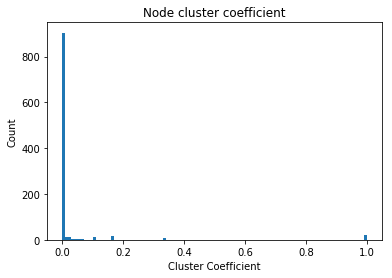

Cluster coefficient n=1000, m=5


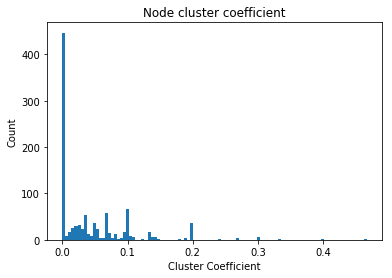

Cluster coefficient n=10000, m=2


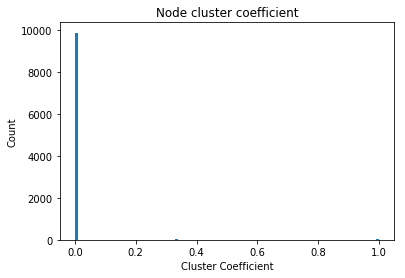

Cluster coefficient n=10000, m=5


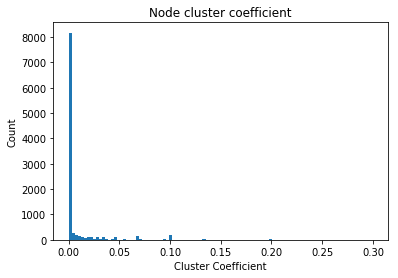

In [15]:
"""
^^^ To above
The nodes with highest degrees seem to serve as hubs offering short paths between the other nodes in the network
"""

print("Diameter for Barbasi n=1000, m=2: Diameter =  ", str(nx.diameter(GB1)))
print("Diameter for Barbasi n=1000, m=5: Diameter = ", str(nx.diameter(GB2)))
print("Diameter for Barbasi n=10000, m=2: Diameter = ", str(nx.diameter(GB3)))
print("Diameter for Barbasi n=10000, m=5: Diameter = ", str(nx.diameter(GB4)))

def cluster_coeff(G):
    lst = []
    for node in G.nodes():
        neighbors = [n for n in nx.neighbors(G,node)]
        numb = len(neighbors)
        links = 0
        
        if numb >1:
            for node1 in neighbors:
                for node2 in neighbors:
                    if G.has_edge(node1,node2):
                        links+=1
            
            links /= 2
            clustering_coeff = links/(.5*numb*(numb-1))
            lst.append(clustering_coeff)
        
        else:
            lst.append(0)
        
    return lst


print("Cluster coefficient n=1000, m=2")
xax = cluster_coeff(GB1)

plt.hist(xax,100)
plt.title('Node cluster coefficient')
plt.xlabel('Cluster Coefficient')
plt.ylabel('Count')

plt.show()

print("Cluster coefficient n=1000, m=5")
xax2 = cluster_coeff(GB2)

plt.hist(xax2,100)
plt.title('Node cluster coefficient')
plt.xlabel('Cluster Coefficient')
plt.ylabel('Count')

plt.show()

print("Cluster coefficient n=10000, m=2")
xax3 = cluster_coeff(GB3)

plt.hist(xax3,100)
plt.title('Node cluster coefficient')
plt.xlabel('Cluster Coefficient')
plt.ylabel('Count')

plt.show()

print("Cluster coefficient n=10000, m=5")
xax4 = cluster_coeff(GB4)

plt.hist(xax4,100)
plt.title('Node cluster coefficient')
plt.xlabel('Cluster Coefficient')
plt.ylabel('Count')

plt.show()

## Task 3: Another Candidate Model for Describing Social Networks
### As you know, the Watts-Strogatz generative model was proposed in 1998 in order to address certain limitation(s) of Erdos-Renyi random graphs in the context of modeling real-world social networks. In this task and the next, you will examine the properties of Watts-Strogatz networks and compare them with those of Barabasi-Albert networks (one of whose objectives is to model social networks) as well as ER random graphs. 

In [ ]:
"""ok"""

### Using NetworkX generate three Watts-Strogatz Random Graphs (WSRGs) with n = 1000 nodes and with parameters k = 5, and p = 0.2, 0.5, and 0.8.

In [16]:
W1 = nx.watts_strogatz_graph(1000,5,0.2)
W2 = nx.watts_strogatz_graph(1000,5,0.5)
W3 = nx.watts_strogatz_graph(1000,5,0.8)

#nx.write_gml(W1,'watts1.gml')
#nx.write_gml(W2,'watts2.gml')
#nx.write_gml(W3,'watts3.gml')

### Use NetworkX to store the graphs in .gml and then visualize them using Gephi. Include your visualizations in SVG format in your notebook.


"""Stogatz n=1000, k = 5, p = .2"""
![Stogatz_p2](stogatz_.2.png)

"""Stogatz n=1000, k = 5, p = .5"""
![Stogatz_p5](stogatz_.5.png)

"""Stogatz n=1000, k = 5, p = .8"""
![Stogatz_p8](stogatz_.8.png)


### Plot the degree distibution of these graphs in arithmetic and log-log scale figures. Based on the plots, do you think Watts-Strogatz networks follow a power-law degree distribution? Why or why not?

p = .2


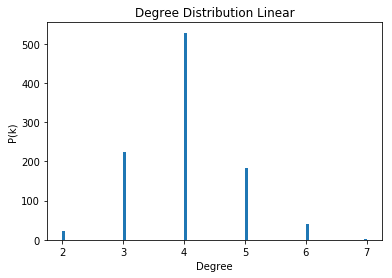

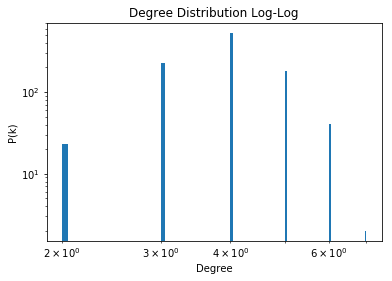

p = .5


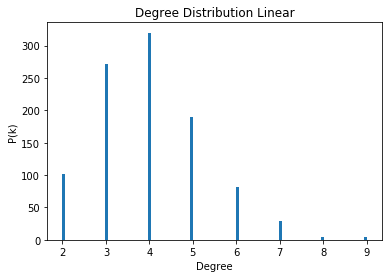

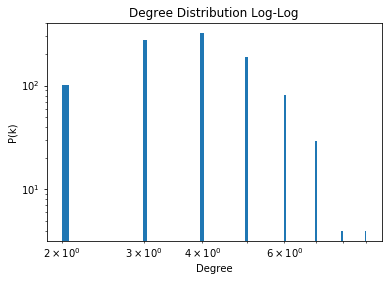

p = .8


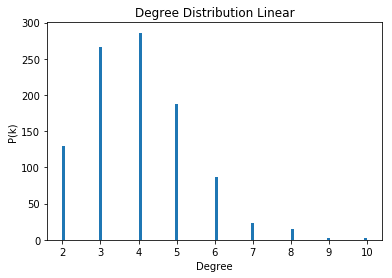

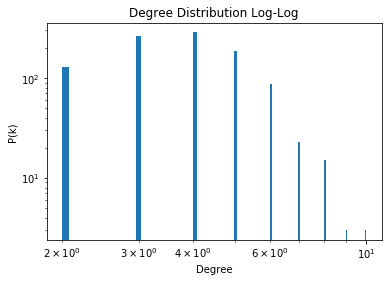

In [18]:
def plot_degdist_linear(G):
    deg = [G.degree(n) for n in G.nodes()]
    plt.hist(deg,100)
    plt.xlabel('Degree')
    plt.ylabel('P(k)')
    plt.title('Degree Distribution Linear')
    plt.show()

def plot_degdist_log(G):
    deg = [G.degree(n) for n in G.nodes()]
    plt.hist(deg,100)
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Degree Distribution Log-Log')
    plt.xlabel('Degree')
    plt.ylabel('P(k)')
    plt.show()

    
print("p = .2")
plot_degdist_linear(W1)
plot_degdist_log(W1)

print("p = .5")
plot_degdist_linear(W2)
plot_degdist_log(W2)

print("p = .8")
plot_degdist_linear(W3)
plot_degdist_log(W3)

"""
I would say the networks do not follow power law distributions because from the graphs, it appears the tails of the distribution
as shown in the log-log plot decay far too rapidly. 
"""

### Calculate the diamaters and the average shortest path lengths of these graphs. Also plot the clustering coefficients of the nodes of these graphs. Compare these results with the ones you obtained for the Barabasi-Albert model. Based on this comparison, which of the two models is a better choice for describing online social networks in your opinion? Explain your answer.

Diameter for Strogatz n=1000, k=5, p=.2:   12
Diameter for Strogatz n=1000, k=5, p=.5:   9
Diameter for Strogatz n=1000, k=5, p=.8:   9
cluster coefficient p = .2


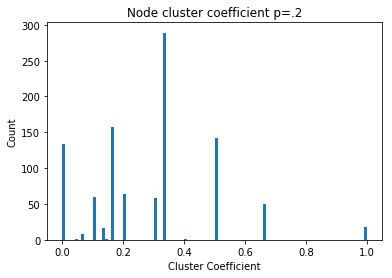

cluster coefficient p = .5


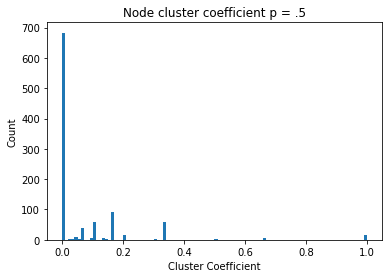

cluster coefficient p = .8


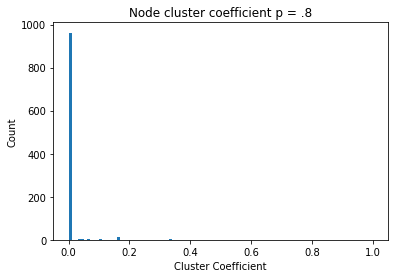

In [19]:
print("Diameter for Strogatz n=1000, k=5, p=.2:  ", str(nx.diameter(W1)))
print("Diameter for Strogatz n=1000, k=5, p=.5:  ", str(nx.diameter(W2)))
print("Diameter for Strogatz n=1000, k=5, p=.8:  ", str(nx.diameter(W3)))

xax4 = cluster_coeff(W1)
print("cluster coefficient p = .2")
plt.hist(xax4,100)
plt.title('Node cluster coefficient p=.2')
plt.xlabel('Cluster Coefficient')
plt.ylabel('Count')

plt.show()

xax5 = cluster_coeff(W2)
print("cluster coefficient p = .5")
plt.hist(xax5,100)
plt.title('Node cluster coefficient p = .5')
plt.xlabel('Cluster Coefficient')
plt.ylabel('Count')

plt.show()

xax6 = cluster_coeff(W3)
print("cluster coefficient p = .8")
plt.hist(xax6,100)
plt.title('Node cluster coefficient p = .8')
plt.xlabel('Cluster Coefficient')
plt.ylabel('Count')

plt.show()

"""
I would argue the Watts-Strogatz network is better suited for modeling social networks because its nodes exhibit a higher
cluster coefficient, which you would expect to see in a social network. Also, the fact that the network obeys scale-free properties,
namely, a degree distribution following the power law is in line with expectations. My only concern is that the diameter of 
the network may be too large when you consider how easy it should be to find a path between any two nodes in a social network
"""

### Now, consider a network that describes the hierarchical structure of an organization, i.e., a network that captures the hierarchical connections between the employees of the organization. It is a network in which two employees are connected by an edge if and only if one of them is the immediate supervisor/boss of the other. Do you think either of the two models that you have examined so far is suitable for describing such a hierarchical network? Why or why not? You may assume that if an employee has two or more immediate supervisors, then all of these supervisors are located at the same level in the hierarchy of the organization

In [ ]:
"""
The barabasi-Albert model would model this ogranization better because the networks appear to have core nodes with high connectivity
to nodes with lower degrees. It also exhibits a smaller clustering coefficient than the stogatz model which you might expect as
the company's lower employees do not share an edge. 
"""

## Task 4 (Bonus Task): Do the above models outperform ER Random Graphs?

### Using NetworkX generate six Erdos Renyi Random Graphs (ERRGs) with n = 1000 nodes and with parameters p = 0.5/n, 1/n, 1.5/n, 0.5ln(n)/n, ln(n)/n, 1.5ln(n)/n.  

### Calculate the diamaters and the average shortest path lengths of these graphs. Also plot the clustering coefficients of the nodes of these graphs. Compare these results with the ones you obtained for the previous models. Based on your comparison, do you think that the Barabasi-Albert and the Watts-Strogatz models are better choices than the Erdos-Renyi Model for describing online social networks? Explain your answer.